In [15]:
import numpy as np
import time
from dataset import ptb
import matplotlib.pyplot as plt

In [6]:
class Rnnlm:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed = (rn(V, D) / 100).astype('f')
        rnnWx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnnWh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnnb = np.zeros(H).astype('f')
        affineW = (rn(H, V) / np.sqrt(H)).astype('f')
        affineb = np.zeros(V).astype('f')
        
        self.params = [embed, rnnWx, rnnWh, rnnb, affineW, affineb]
        self.grads = []
        self.rnn = []
        
        self.wordvec_size = wordvec_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.time_idx = 0
    
    def forward(self, x, t):
        embed, rnnWx, rnnWh, rnnb, affineW, affineb = self.params
        
        batch_size, time_size = x.shape
        wordvec_size = self.wordvec_size
        hidden_size = self.hidden_size
        
        h_prev = np.zeros((batch_size, hidden_size), dtype='f')
        hs = np.empty((batch_size, time_size, hidden_size), dtype='f')
        for t in range(time_size):
            # embed
            emb_out = embed[x[:, t]]
            
            #rnn
            h_next = np.matmul(h_prev, rnnWh) + np.matmul(emb_out, rnnWx) + rnnb
            h_next = np.tanh(h_next)
            
            self.rnn.append([emb_out, h_prev, h_next])
            h_prev = h_next
            hs[:, t, :] = h_prev
        
        # affine
        affine_out = np.matmul(hs, affineW) + affineb
        
        # softmax
        y = self.softmax(affine_out)
        
        loss = self.getLoss(y, batch_t)
        self.xs = x, hs, affine_out, y

        return y, loss
    
    def backward(self, t):
        embed, rnnWx, rnnWh, rnnb, affineW, affineb = self.params
        x, hs, affine_out, y = self.xs
        
        wordvec_size = self.wordvec_size
        vocab_size = self.vocab_size
        batch_size, time_size = x.shape
        
        # softmax
        y = y.reshape(batch_size * time_size, -1)
        t = t.reshape(batch_size * time_size)
        y[np.arange(batch_size * time_size), t] -= 1
        soft_dout = y
        
        # affine
        affine_dout = np.matmul(soft_dout, affineW.T).reshape(batch_size, time_size, -1) # (b, t, h)
        affinedW = np.matmul(hs.reshape(batch_size * time_size, -1).T, soft_dout) # (h, v)
        affinedb = np.sum(soft_dout, axis=0)
        
        # rnn
        rnndWx = np.zeros_like(rnnWx)
        rnndWh = np.zeros_like(rnnWh)
        rnndb = np.zeros_like(rnnb)
        
        rnn_douts = np.empty((batch_size, time_size, wordvec_size), dtype='f')
        dh = 0
        for t in reversed(range(time_size)):
            emb_out, h_prev, h_next = self.rnn[t]
            
            dh_next = affine_dout[:, t, :] + dh
            tanh_dout = dh_next * (1 - h_next ** 2)
            
            dWx = np.matmul(emb_out.T, tanh_dout)
            rnn_dout = np.matmul(tanh_dout, rnnWx.T)
            rnn_douts[:, t, :] = rnn_dout
            
            dWh = np.matmul(h_prev.T, tanh_dout)
            dh_prev = np.matmul(tanh_dout, rnnWh.T)
            
            db = np.sum(tanh_dout, axis=0)
            
            rnndWx += dWx
            rnndWh += dWh
            rnndb += db
            
            dh = dh_prev
        
        # embed
        embed_dout = np.zeros_like(embed)
        for t in range(time_size):
            np.add.at(embed_dout, x[:, t], rnn_douts[:, t, :])
        
        self.grads = embed_dout, rnndWx, rnndWh, rnndb, affinedW, affinedb
        
        
    def softmax(self, y):
        y = y - np.max(y)
        y = np.exp(y)
        y = y / y.sum(axis=2, keepdims=True)
        return y
    
    def update(self, lr):
        for i in range(len(self.params)):
            self.params[i] -= self.grads[i] * lr      
            
    def getLoss(self, y, t):
        N, T, V = y.shape

        y = y.reshape(N * T, V)
        t = t.reshape(N * T)

        ls = np.log(y[np.arange(N * T), t])
        return -np.sum(ls) / (N * T)
    
    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

In [3]:
# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.01
max_epoch = 100
max_iters = len(xs) // (batch_size * time_size)
eval_interval = 20

In [18]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)

In [19]:
ppl_list = []
total_loss = 0
loss_count = 0
start_time = time.time()
model.time_idx = 0
for epoch in range(max_epoch):
    for iters in range(max_iters):
        batch_x, batch_t = model.get_batch(xs, ts, batch_size, time_size)

        y, loss = model.forward(batch_x, batch_t)
        model.backward(batch_t)
        model.update(lr)
        
        total_loss += loss
        loss_count += 1

        if ((iters % eval_interval) == 0):
            ppl = np.exp(total_loss / loss_count)
            elapsed_time = time.time() - start_time
            print('| 에폭 %d | 시간 %d[s] | loss %.2f | 퍼플렉서티 %.2f'
                % (epoch + 1, elapsed_time, loss, ppl))
            ppl_list.append(float(ppl))
            total_loss, loss_count = 0, 0

| 에폭 1 | 시간 0[s] | loss 6.03 | 퍼플렉서티 417.35
| 에폭 2 | 시간 0[s] | loss 5.16 | 퍼플렉서티 321.76
| 에폭 3 | 시간 0[s] | loss 5.63 | 퍼플렉서티 227.37
| 에폭 4 | 시간 0[s] | loss 5.52 | 퍼플렉서티 206.60
| 에폭 5 | 시간 0[s] | loss 5.11 | 퍼플렉서티 197.71
| 에폭 6 | 시간 0[s] | loss 5.34 | 퍼플렉서티 191.59
| 에폭 7 | 시간 0[s] | loss 5.11 | 퍼플렉서티 174.86
| 에폭 8 | 시간 0[s] | loss 5.34 | 퍼플렉서티 170.00
| 에폭 9 | 시간 0[s] | loss 5.15 | 퍼플렉서티 160.34
| 에폭 10 | 시간 0[s] | loss 5.03 | 퍼플렉서티 148.52
| 에폭 11 | 시간 0[s] | loss 5.07 | 퍼플렉서티 142.75
| 에폭 12 | 시간 0[s] | loss 5.05 | 퍼플렉서티 132.31
| 에폭 13 | 시간 0[s] | loss 5.07 | 퍼플렉서티 127.37
| 에폭 14 | 시간 0[s] | loss 4.68 | 퍼플렉서티 117.03
| 에폭 15 | 시간 0[s] | loss 4.32 | 퍼플렉서티 107.12
| 에폭 16 | 시간 0[s] | loss 4.43 | 퍼플렉서티 101.90
| 에폭 17 | 시간 0[s] | loss 4.62 | 퍼플렉서티 93.18
| 에폭 18 | 시간 0[s] | loss 4.77 | 퍼플렉서티 84.37
| 에폭 19 | 시간 0[s] | loss 4.65 | 퍼플렉서티 75.51
| 에폭 20 | 시간 0[s] | loss 4.40 | 퍼플렉서티 68.26
| 에폭 21 | 시간 0[s] | loss 4.11 | 퍼플렉서티 64.04
| 에폭 22 | 시간 0[s] | loss 3.61 | 퍼플렉서티 57.37
| 에폭 23 | 시간 0[s] | loss 

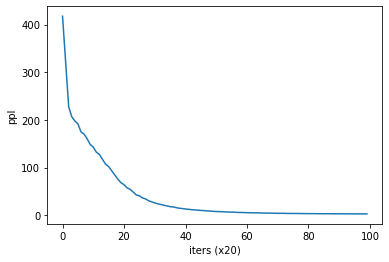

In [20]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('iters (x' + str(eval_interval) + ')')
plt.ylabel('ppl')
plt.show()